# Project: Credit Risk Analysis

This project is a credit risk assessment system that uses machine learning to analyze borrowers' income, credit utilization rate, and overdue records to predict default risk. 

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

## 1. Data Exploration

In [10]:
org = pd.read_csv("../data/credit.csv", index_col=1)
org.head(5)

,Unnamed: 0,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,,,,,,,,,,,
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
0,2,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
0,3,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
0,4,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
0,5,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


**Column Explanation**

- SeriousDlqin2yrs: 90 days or more of overdue behavior (i.e., defining good and bad loans)

- RevolvingUtilizationOfUnsecuredLines: The ratio of available loan and credit card lines to total lines

- age: Borrower's age

- NumberOfTime30-59DaysPastDueNotWorse: The number of overdue 35-59 days in the past two years but no worse

- DebtRatio: Monthly debt repayment, alimony, living expenses divided by monthly total income

- MonthlyIncome: Monthly income

- Number rOfOpenCreditLinesAndLoans: Number of open loans and lines of credit

- NumberOfTimes90DaysLate: Number of times a borrower is 90 days or more past due

- NumberRealEstateLoansOrLines: Number of mortgage and real estate loans, including home equity lines of credit

- NumberOfTime60-89DaysPastDueNotWorse: Number of times a loan is 60-89 days past due but has not progressed to a worse state in the past two years

- NumberOfDependents: Number of dependents in the household excluding oneself (spouse, children, etc.)

In [11]:
# check the number of rows and columns
print(org.shape)
# check basic information
print(org.describe(include='all', percentiles=[0.5]).T.round(2))

(150000, 11)
                                         count      mean       std  min  \
Unnamed: 0                            150000.0  75000.50  43301.41  1.0   
RevolvingUtilizationOfUnsecuredLines  150000.0      6.05    249.76  0.0   
age                                   150000.0     52.30     14.77  0.0   
NumberOfTime30-59DaysPastDueNotWorse  150000.0      0.42      4.19  0.0   
DebtRatio                             150000.0    353.01   2037.82  0.0   
MonthlyIncome                         120269.0   6670.22  14384.67  0.0   
NumberOfOpenCreditLinesAndLoans       150000.0      8.45      5.15  0.0   
NumberOfTimes90DaysLate               150000.0      0.27      4.17  0.0   
NumberRealEstateLoansOrLines          150000.0      1.02      1.13  0.0   
NumberOfTime60-89DaysPastDueNotWorse  150000.0      0.24      4.16  0.0   
NumberOfDependents                    146076.0      0.76      1.12  0.0   

                                           50%        max  
Unnamed: 0                

## 2. Data Cleaning

### 2.1 remove duplications

In [12]:
org.drop_duplicates(inplace=True)
print(org.shape)

(150000, 11)


### 2.2. missing values

In [13]:
org.isnull().mean()

Unnamed: 0                              0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.198207
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.026160
dtype: float64

Two columns have missing values, and the missing proportion of monthly income is relatively high

<Axes: >

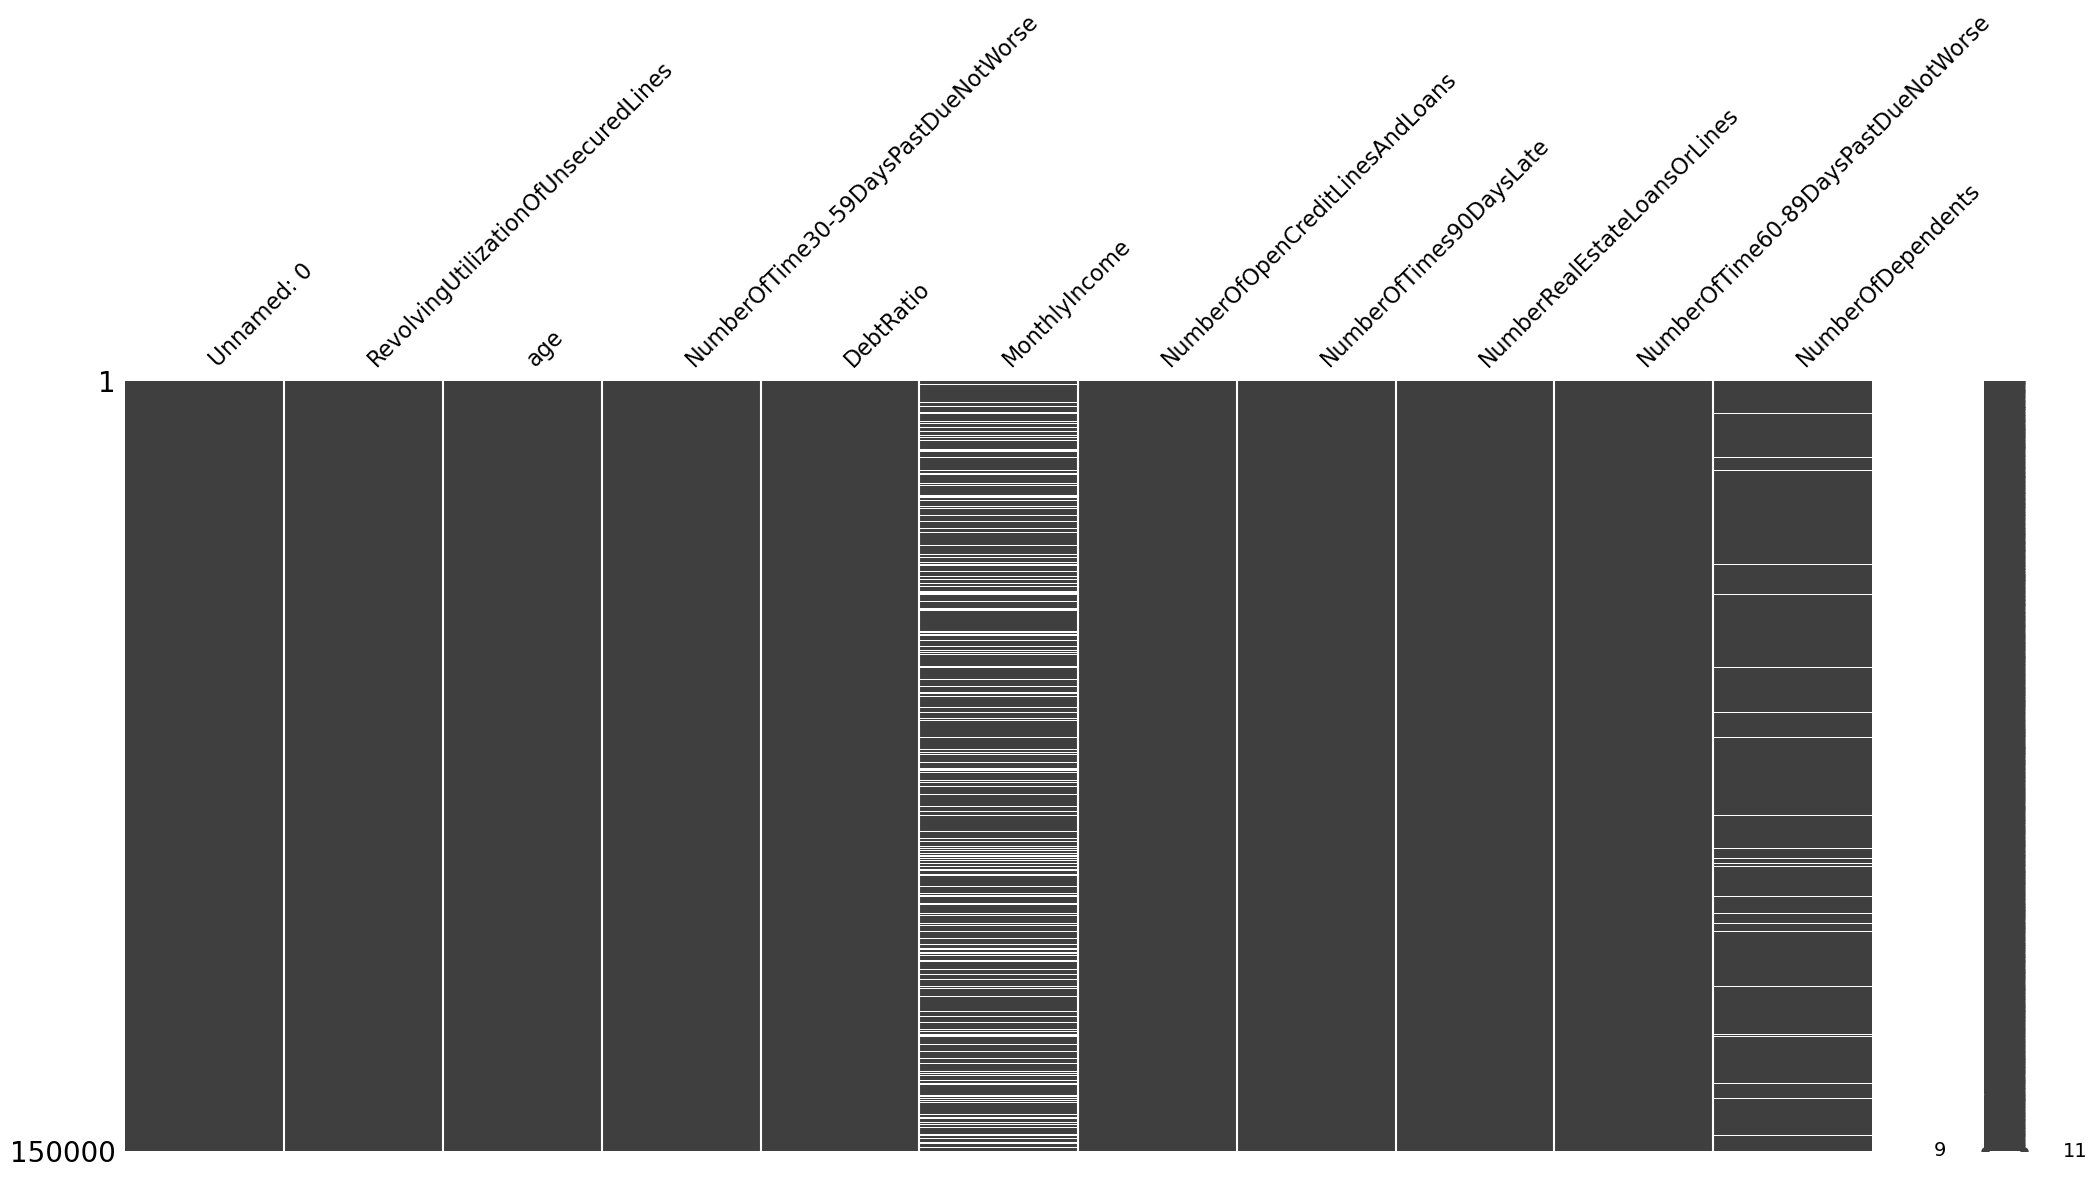

In [14]:
# visualization tool for missing values
import missingno as msno
msno.matrix(org)

**Missing Values Processing Logic:**

- Missing rate of 'NumberOfDependents' is only 2.61%, deleting them is acceptable. (Optional) But we can also analyze further, we can check if missing values in NumberOfDependents occur randomly. 

- Missing rate of 'MonthlyIncome' is high (19.8%), and income is a right-skewed variable (A few people earn very high salaries ). And missing MonthlyIncome may indicate financial distress, so we cannot simply delete them, filling with the median is more robust than the mean.


In [15]:
missing_dependents = org[org['NumberOfDependents'].isnull()]

# Compare means of other variables between missing and non-missing rows
comparison = org.groupby(org['NumberOfDependents'].isnull()).mean()
print(comparison)

                      Unnamed: 0  RevolvingUtilizationOfUnsecuredLines  \
NumberOfDependents                                                       
False               75013.668597                              5.922272   
True                74510.281855                             10.745132   

                          age  NumberOfTime30-59DaysPastDueNotWorse  \
NumberOfDependents                                                    
False               52.099277                              0.407945   
True                59.588940                              0.908257   

                      DebtRatio  MonthlyIncome  \
NumberOfDependents                               
False                333.373603    6670.221237   
True                1083.812181            NaN   

                    NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
NumberOfDependents                                                             
False                                      8.529279      

NumberOfDependents is not missing randomly. It depends on other variables (income, debt ratio, delinquencies, age etc.) 

In [16]:
df = org.copy()
# Median imputation
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
# Drop rows with missing NumberOfDependents values
df.dropna(subset=['NumberOfDependents'], inplace=True)
# Check the shape again
print(df.shape)

(146076, 11)


C:\Users\g1951\AppData\Local\Temp\ipykernel_18000\1304971453.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)


### 2.3 anomaly

We can also check anomaly with simple visualization

In [17]:
# check age distribution
print(df.age.value_counts().sort_index())

# delete rows with 0 age
df = df.loc[df.age>0]

#check again
print(df.age.value_counts().sort_index())

age
0        1
21     152
22     396
23     599
24     760
      ... 
99       5
101      3
102      3
103      3
107      1
Name: count, Length: 84, dtype: int64
age
21     152
22     396
23     599
24     760
25     909
      ... 
99       5
101      3
102      3
103      3
107      1
Name: count, Length: 83, dtype: int64


We can also check anomaly with simple visualization

<Axes: >

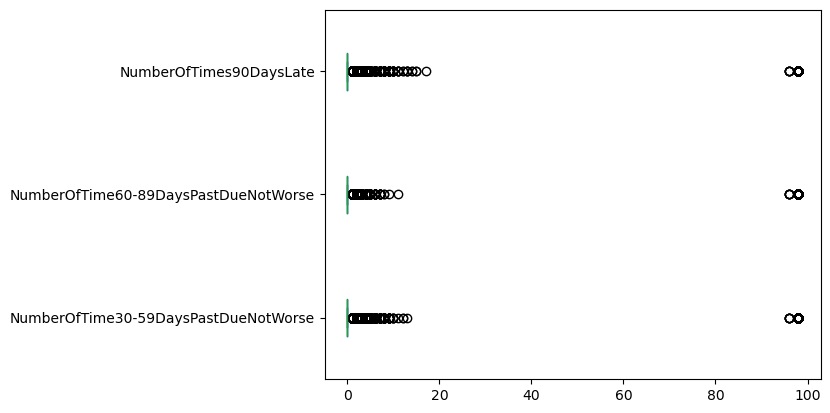

In [18]:
columns=['NumberOfTime30-59DaysPastDueNotWorse',
         'NumberOfTime60-89DaysPastDueNotWorse',
         'NumberOfTimes90DaysLate']

df[columns].plot.box(vert = False)

From a business perspective, such a high number of 100 should not occur, so these abnormal data are also deleted here.

<Axes: >

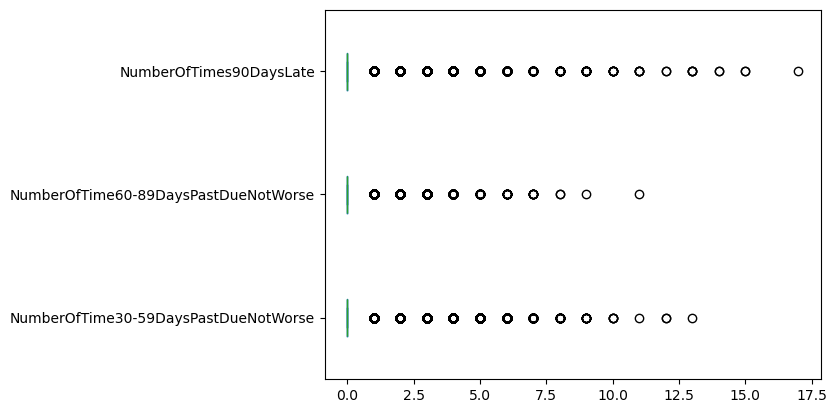

In [19]:
# delete abnormal data
for i in columns:
    df = df.loc[df[i] < 80]
    
#check again
df[columns].plot.box(vert = False)

## 3. Data Analysis

### State of Loans

In [20]:
#SeriousDlqin2yrs is the target value.
df.index.value_counts()

SeriousDlqin2yrs
0    136125
1      9712
Name: count, dtype: int64

Text(0, 0.5, '% of Condition of Loans')

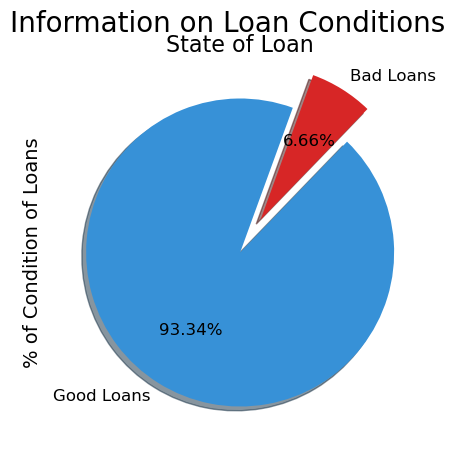

In [21]:
# visualization
plt.figure(figsize=(10,5))
colors = ["#3791D7", "#D72626"]
labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=20)

df.index.value_counts().plot.pie(explode=[0,0.25], \
autopct='%1.2f%%', shadow=True, colors=colors,\
labels=labels, fontsize=12, startangle=70)

plt.title('State of Loan', fontsize=16)
plt.ylabel('% of Condition of Loans', fontsize=14)

### Age Distribution

C:\Users\g1951\AppData\Local\Temp\ipykernel_18000\210880983.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="age", data=df, palette='RdYlGn_r')


Text(0.5, 1.0, 'Age')

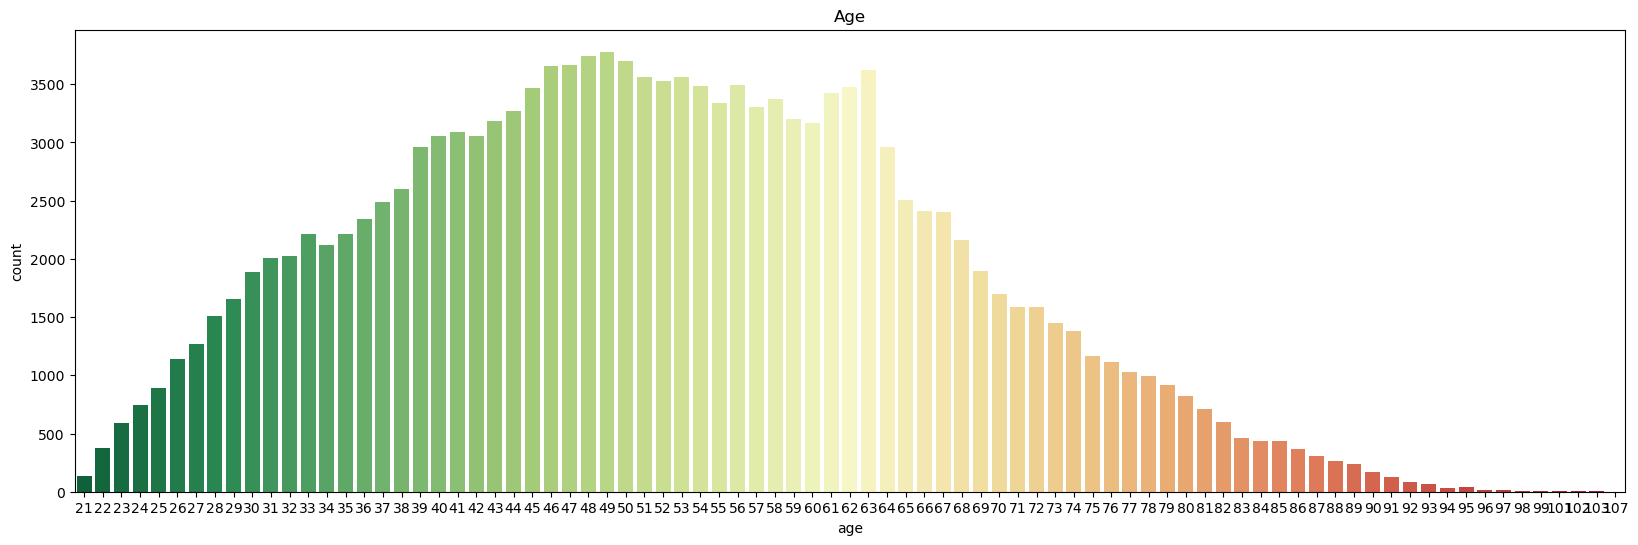

In [22]:
plt.figure(figsize=(20,6))
sns.countplot(x="age", data=df, palette='RdYlGn_r')
plt.title('Age')

### Income Distribution

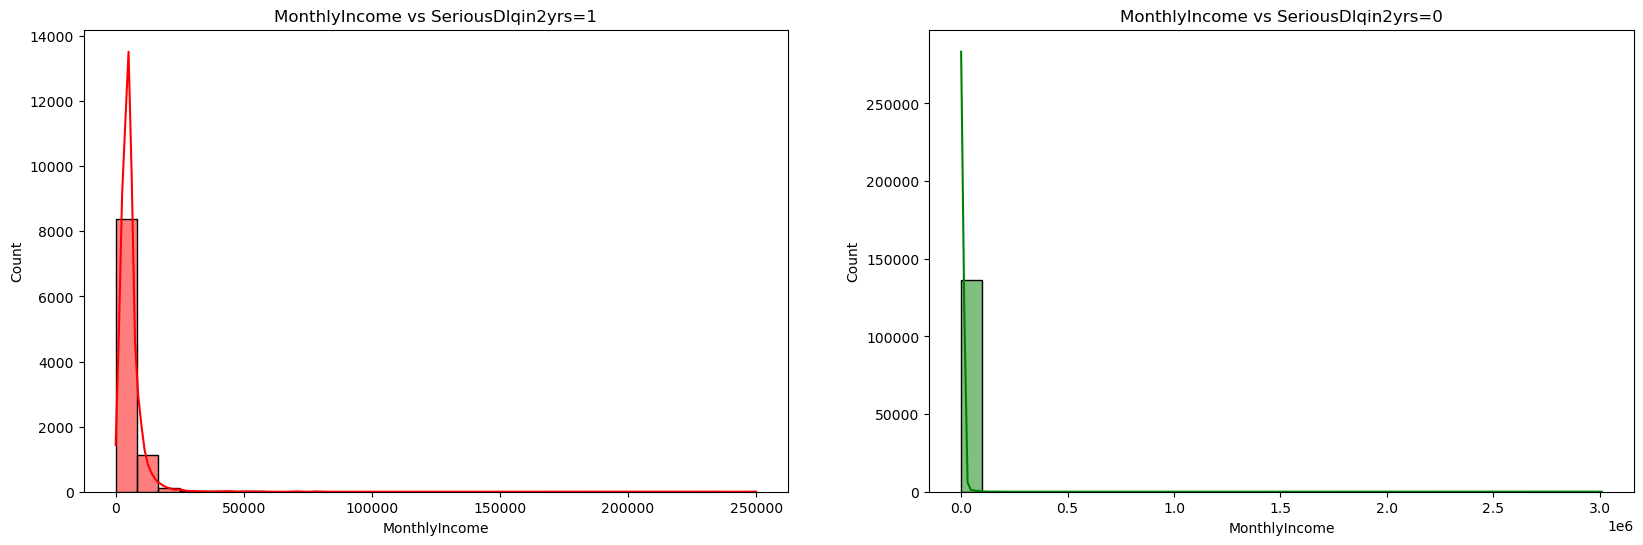

In [23]:
# Create subplots
f, ax = plt.subplots(1, 2, figsize=(20,6))

# Plot for SeriousDlqin2yrs=1
sns.histplot(df[df.index == 1]['MonthlyIncome'], bins=30, kde=True, ax=ax[0], color='red')
ax[0].set_title('MonthlyIncome vs SeriousDlqin2yrs=1')

# Plot for SeriousDlqin2yrs=0
sns.histplot(df[df.index == 0]['MonthlyIncome'], bins=30, kde=True, ax=ax[1], color='green')
ax[1].set_title('MonthlyIncome vs SeriousDlqin2yrs=0')

# Show plot
plt.show()

Since we observed that a small number of people have extremely high incomes, these outliers can distort the visualization. To get a clearer distribution, we can exclude the top 1% of values by filtering MonthlyIncome **below the 99th percentile**.

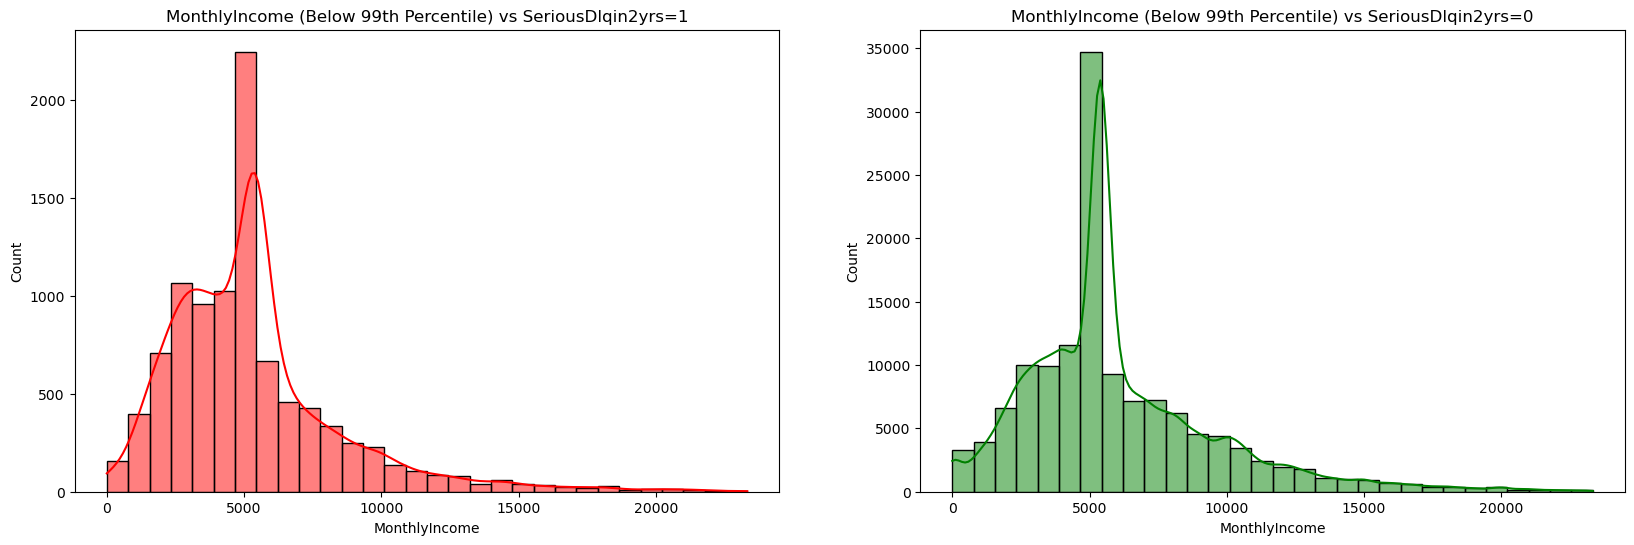

In [24]:
# Compute the 99th percentile threshold
income_threshold = np.percentile(df['MonthlyIncome'].dropna(), 99)

# Filter out extreme values (keep only those below 99th percentile)
df_filtered = df[df['MonthlyIncome'] <= income_threshold]

# Create subplots
f, ax = plt.subplots(1, 2, figsize=(20,6))

# Plot for SeriousDlqin2yrs=1 (defaulted)
sns.histplot(df_filtered[df_filtered.index == 1]['MonthlyIncome'], bins=30, kde=True, ax=ax[0], color='red')
ax[0].set_title('MonthlyIncome (Below 99th Percentile) vs SeriousDlqin2yrs=1')

# Plot for SeriousDlqin2yrs=0 (not defaulted)
sns.histplot(df_filtered[df_filtered.index == 0]['MonthlyIncome'], bins=30, kde=True, ax=ax[1], color='green')
ax[1].set_title('MonthlyIncome (Below 99th Percentile) vs SeriousDlqin2yrs=0')

# Show plot
plt.show()

### Correlation Matrix

[Text(1, -1.0, '−1.0'),
 Text(1, -0.5, '−0.5'),
 Text(1, 0.0, '0.0'),
 Text(1, 0.5, '0.5'),
 Text(1, 1.0, '1.0')]

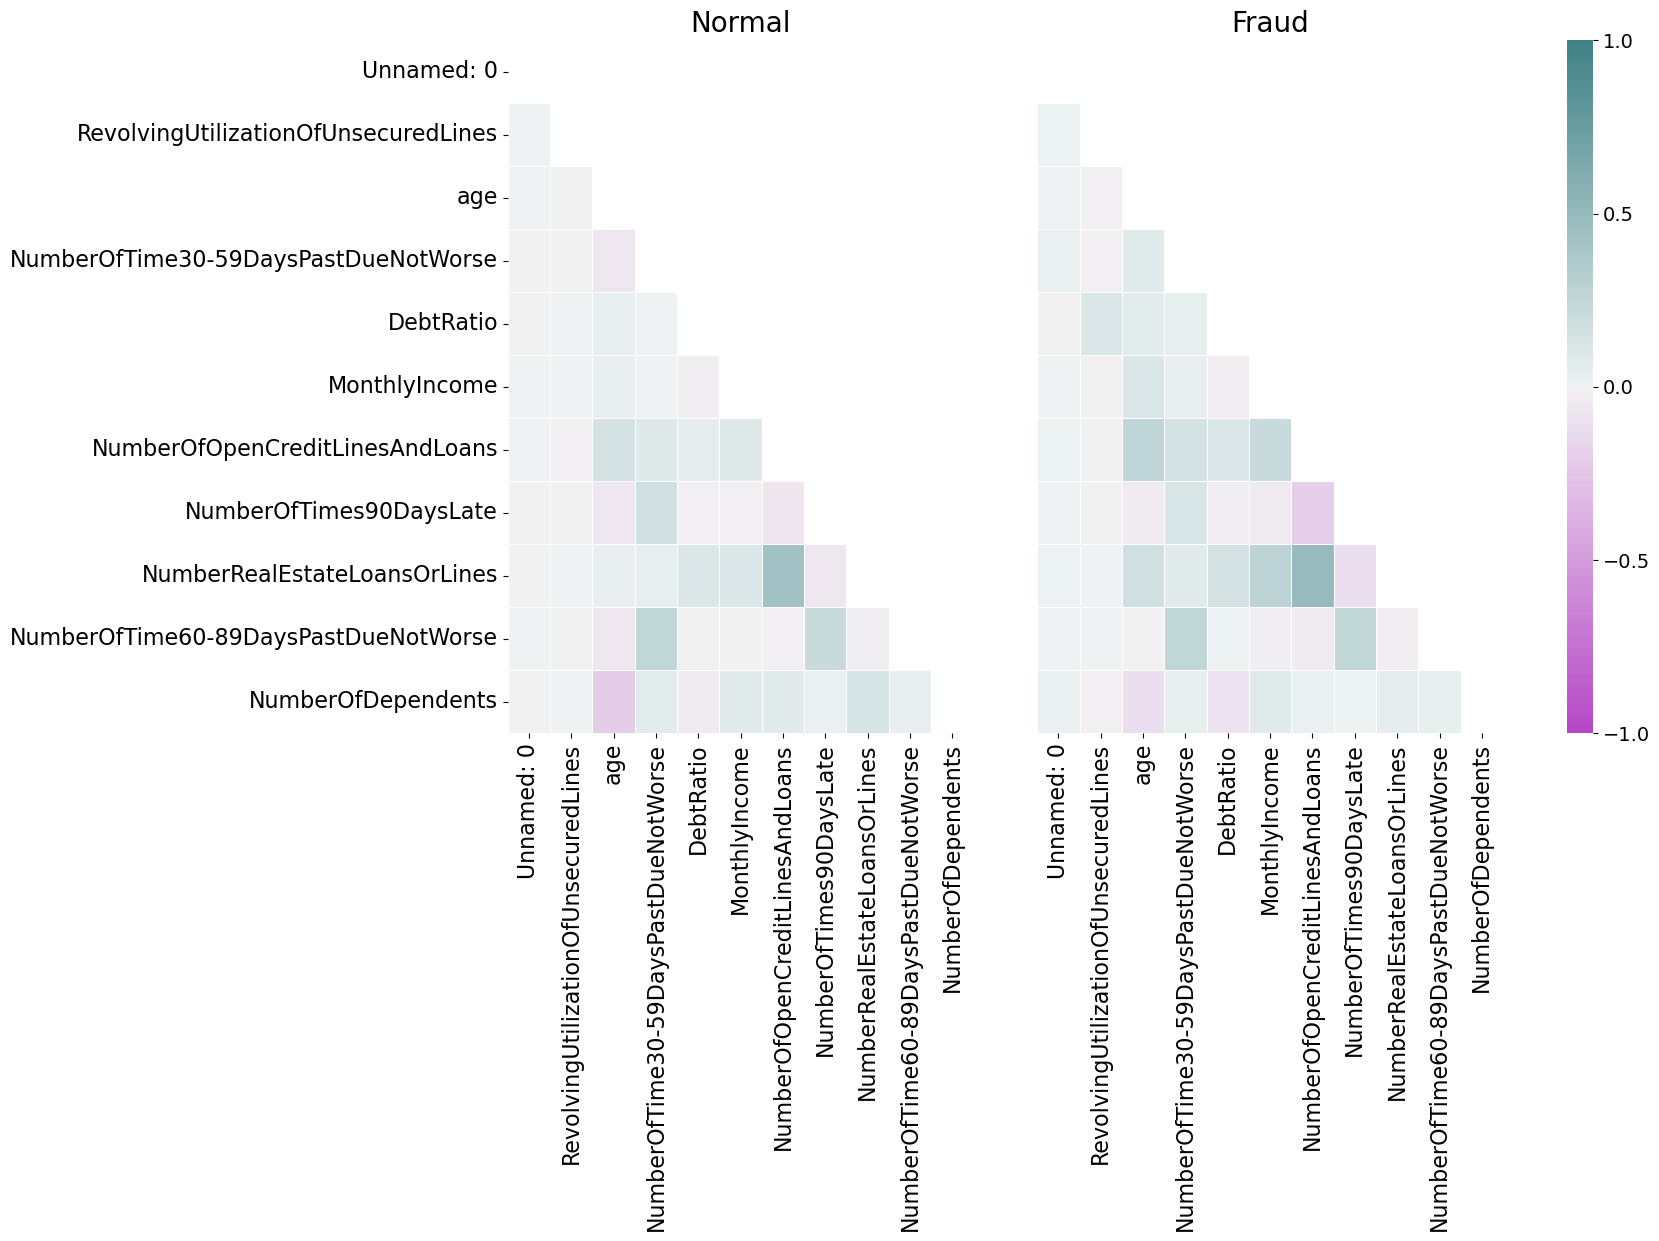

In [25]:
# update Xfraud & XnonFraud with cleaned data
Xfraud = df.loc[df.index == 1]
XnonFraud = df.loc[df.index == 0]

# normal
correlationNonFraud = XnonFraud.loc[:, df.columns].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True
grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, figsize = (14, 9))
cmap = sns.diverging_palette(300, 200, as_cmap=True)

ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
                cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16)
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16)
ax1.set_title('Normal', size = 20)

# fraud
correlationFraud = Xfraud.loc[:, df.columns].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
                  ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
                  cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16)
ax2.set_title('Fraud', size = 20)

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14)

If the correlation patterns differ significantly, it suggests that certain features behave differently for fraud cases vs. non-fraud cases, which can help in fraud detection.

We can conclude some interesting patterns from the matrix. For example, NumberOfOpenCreditLinesAndLoans vs. NumberOfTimes90DaysLate, the correlance is significantly high among frauds, which indicates that fraudulent users tend to apply for multiple loans at the same time and overdue them.

In [26]:
# drop the first row (Unnamed: 0)
df.drop('Unnamed: 0',axis=1, inplace=True)

df['SeriousDlqin2yrs'] = df.index
df.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'SeriousDlqin2yrs'],
      dtype='object')

### Feature Importance

In [27]:
# extract features
x_feature = list(df.columns)
x_feature.remove('SeriousDlqin2yrs')

x_val = df[x_feature]
y_val = df['SeriousDlqin2yrs']

# random forest
names = df[x_feature].columns
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,random_state=123) #create classifier
clf.fit(x_val, y_val) #fit
# names, clf.feature_importances_
for feature in zip(names, clf.feature_importances_):
    print(feature)

('RevolvingUtilizationOfUnsecuredLines', 0.1988166022722875)
('age', 0.12577661046253663)
('NumberOfTime30-59DaysPastDueNotWorse', 0.04845279889971477)
('DebtRatio', 0.18025905060902692)
('MonthlyIncome', 0.1483271924190806)
('NumberOfOpenCreditLinesAndLoans', 0.08931755269520165)
('NumberOfTimes90DaysLate', 0.09113048049864415)
('NumberRealEstateLoansOrLines', 0.03383421811189638)
('NumberOfTime60-89DaysPastDueNotWorse', 0.041291914660421626)
('NumberOfDependents', 0.04279357937118979)


(-1.0, 10.0)

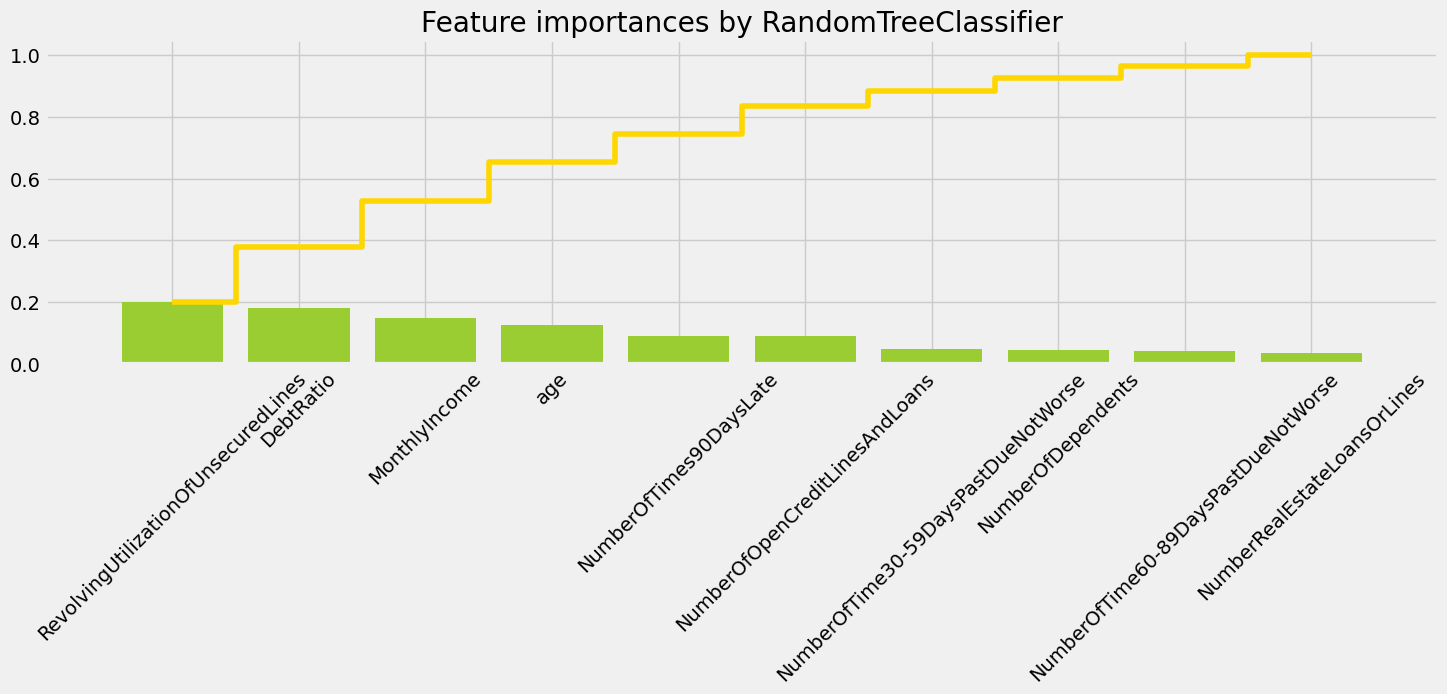

In [28]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)

# feature importances
importances = clf.feature_importances_
feat_names = names
indices = np.argsort(importances)[::-1]

fig = plt.figure(figsize=(16,4))
plt.title("Feature importances by RandomTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='yellowgreen', align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative',color='gold')
plt.xticks(range(len(indices)), feat_names[indices], rotation=45,fontsize=14)
plt.xlim([-1, len(indices)])

**RevolvingUtilizationOfUnsecuredLines** (Unsecured Credit Utilization Rate): The higher the utilization rate, the greater the risk of default.

### Predictive Model

**Extracts Features and Check Imbalance**

In [29]:
# define featurres and target value
X = df[x_feature]
y = df["SeriousDlqin2yrs"]

# positive and negative sample
n_sample = y.shape[0]
n_pos_sample = y[y == 0].shape[0]
n_neg_sample = y[y == 1].shape[0]
print('Total samples：{}; Positive samples{:.2%}; Negative samples{:.2%}'.format(n_sample,
                                                            n_pos_sample / n_sample,
                                                            n_neg_sample / n_sample))
print('Dimensions：', X.shape[1])

Total samples：145837; Positive samples93.34%; Negative samples6.66%
Dimensions： 10


**SMOTE**

The dataset is highly imbalanced, SMOTE helps to balance this by artificially generating new minority class instances.

In [30]:
# handle class imbalance using SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=13)  # Apply SMOTE oversampling
X, y = sm.fit_resample(X, y)  # Generate synthetic minority class samples

print('After applying SMOTE:')
n_sample = y.shape[0]
n_pos_sample = y[y == 0].shape[0]
n_neg_sample = y[y == 1].shape[0]

print('Total samples: {}; Positive samples: {:.2%}; Negative samples: {:.2%}'.format(
    n_sample, n_pos_sample / n_sample, n_neg_sample / n_sample))

After applying SMOTE:
Total samples: 272250; Positive samples: 50.00%; Negative samples: 50.00%


**Split Dataset and Train a Model**

Random forest is a powerful ensemble model that reduces overfitting and it works well with structured datasets like credit risk analysis.

In [31]:
# split data into training and testing sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,y,test_size=0.3,random_state=16)

# train a random forest classifier
clf=RandomForestClassifier(n_estimators=100,random_state=16)
clf.fit(Xtrain, Ytrain)

RandomForestClassifier(random_state=16)

**Evaluation**

In [32]:
#evaluate the model
from sklearn.metrics import classification_report
print(classification_report(Ytest,clf.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     40978
           1       0.91      0.91      0.91     40697

    accuracy                           0.91     81675
   macro avg       0.91      0.91      0.91     81675
weighted avg       0.91      0.91      0.91     81675



**Plot Precision-Recall Curve**

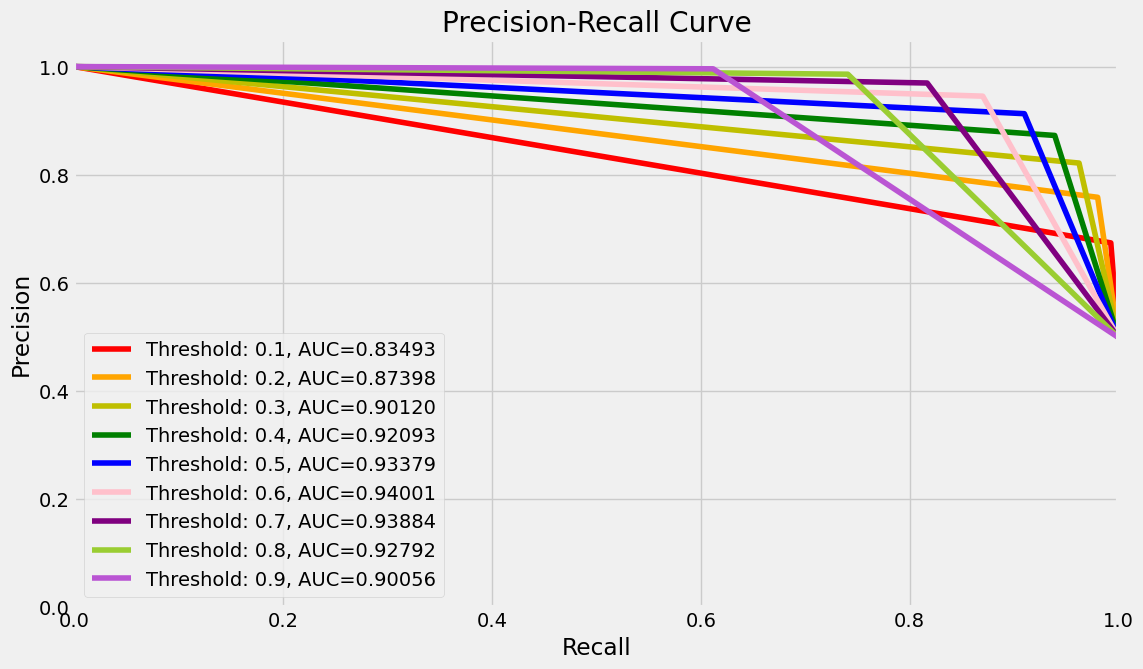

In [33]:
# plot precision-recall curves for different thresholds
from itertools import cycle
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = cycle(['r', 'orange', 'y', 'g', 'blue', 'pink', 'purple', 'yellowgreen', 'mediumorchid'])

plt.figure(figsize=(12,7))
y_pred_proba = clf.predict_proba(Xtest)  # Get predicted probabilities

for i, color in zip(thresholds, colors):
    y_test_predictions_prob = y_pred_proba[:,1] > i  # Classify based on threshold

    precision, recall, _ = precision_recall_curve(Ytest, y_test_predictions_prob)
    area = auc(recall, precision)

    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color, label=f'Threshold: {i}, AUC={area:.5f}')
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

Optimal threshold: 0.6 (AUC=0.94001): Balance precision (reduce false positives) and recall (reduce false negatives). At a threshold of 0.6, the model can effectively identify most bad loans while maintaining a high degree of credibility.

**Business adaptation suggestions:**
- Conservative strategy (focusing on precision): select a threshold of 0.7 (AUC=0.93884) to reduce the misjudgment of good users as bad users.
- Aggressive strategy (focusing on recall): select a threshold of 0.4 (AUC=0.92093) to capture as many potential bad users as possible.